In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame

from math import sqrt
from numpy import concatenate
from pandas import concat

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
case = pd.read_csv('data/new/case_maret_july.csv')

mobility = pd.read_csv('data/new/mobility_maret_july.csv')
weather = pd.read_csv('data/new/weather_maret_july.csv')
mobility.set_index('date', inplace=True)

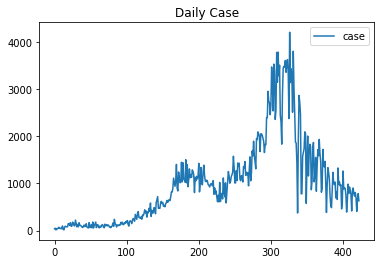

In [4]:
case.plot()
plt.title("Daily Case")
plt.show()

In [5]:
new_weather = weather.interpolate(method='spline', order=2)

new_date = weather[['date']]

new_weather.set_index('date', inplace=True)

In [6]:
case['date'] = case['date'].astype('datetime64[ns]')
case.set_index('date', inplace=True)
case.head()

,case
date,
2020-03-18,38
2020-03-19,50
2020-03-20,14
2020-03-21,44
2020-03-22,36


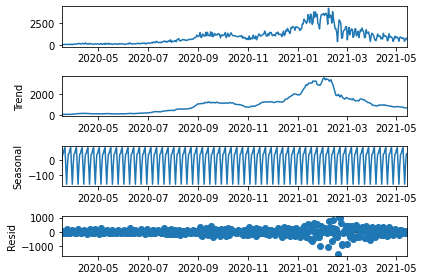

In [7]:
decompose = seasonal_decompose(case, model='additive', extrapolate_trend='freq')

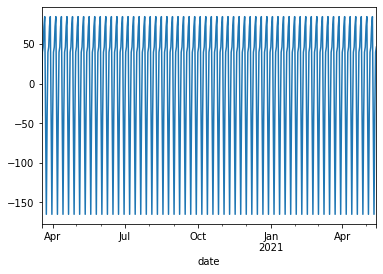

In [27]:
decompose.seasonal.plot()
plt.show()

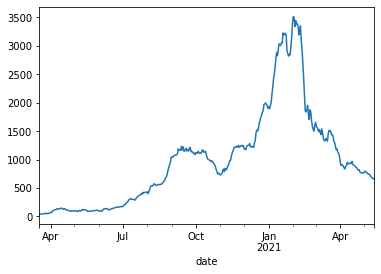

In [28]:
decompose.trend.plot()
plt.show()

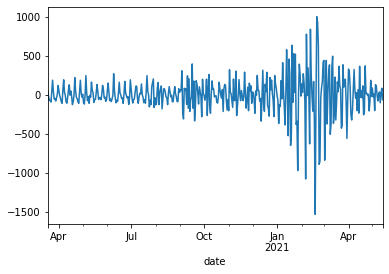

In [26]:
decompose.resid.plot()
plt.show()

In [8]:
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid
actual = decompose.observed

In [9]:
new_trend = trend.to_frame()
new_seasonal = seasonal.to_frame()
new_residual = residual.to_frame()
new_actual = actual.to_frame()

In [10]:
model = ARIMA(new_trend, order=(2,0,1))
model_fit = model.fit()

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [11]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                  423
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2257.248
Date:                Mon, 13 Sep 2021   AIC                           4524.496
Time:                        14:32:39   BIC                           4544.733
Sample:                    03-18-2020   HQIC                          4532.492
                         - 05-14-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        989.8463    567.547      1.744      0.081    -122.525    2102.218
ar.L1          1.7401      0.033     52.870      0.000       1.676       1.805
ar.L2         -0.7426      0.033    -22.614      0.0

In [12]:
hasil = model_fit.forecast(10)

In [13]:
hasil.head()

2021-05-15    642.952970
2021-05-16    639.790114
2021-05-17    638.314723
2021-05-18    638.096136
2021-05-19    638.811408
Freq: D, Name: predicted_mean, dtype: float64

In [14]:
new_seasonal.reset_index(drop=True, inplace=True)
seasonal_data = pd.concat([new_date, new_seasonal], axis=1)
seasonal_data.set_index('date', inplace=True)

new_residual.reset_index(drop=True, inplace=True)
residual_data = pd.concat([new_date, new_seasonal], axis=1)
residual_data.set_index('date', inplace=True)

In [15]:
data_seasonal = pd.concat([seasonal_data, new_weather, mobility], axis=1)

data_residual = pd.concat([residual_data, new_weather, mobility], axis=1)

In [16]:
# frame as supervised learning
reframed_seasonal = series_to_supervised(data_seasonal, 1, 1)
reframed_residual = series_to_supervised(data_residual, 1, 1)

In [17]:
# drop columns we don't want to predict
reframed_seasonal.drop(reframed_seasonal.columns[[12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)
reframed_residual.drop(reframed_residual.columns[[12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)

In [18]:
# split into train and test sets
values= reframed_seasonal.values

#n_total = round((values.shape[0])*80/100)
n_total = 413


train = values[:n_total, :]
test = values[n_total:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(413, 1, 11) (413,) (9, 1, 11) (9,)


Epoch 1/100
83/83 - 0s - loss: 68.5425 - val_loss: 62.2356
Epoch 2/100
83/83 - 0s - loss: 67.7928 - val_loss: 61.2840
Epoch 3/100
83/83 - 0s - loss: 67.0207 - val_loss: 60.4124
Epoch 4/100
83/83 - 0s - loss: 66.3141 - val_loss: 59.6581
Epoch 5/100
83/83 - 0s - loss: 65.5433 - val_loss: 58.8808
Epoch 6/100
83/83 - 0s - loss: 64.7512 - val_loss: 57.8578
Epoch 7/100
83/83 - 0s - loss: 63.9168 - val_loss: 57.1911
Epoch 8/100
83/83 - 0s - loss: 63.1287 - val_loss: 56.7588
Epoch 9/100
83/83 - 0s - loss: 62.2413 - val_loss: 55.9985
Epoch 10/100
83/83 - 0s - loss: 61.4450 - val_loss: 55.2973
Epoch 11/100
83/83 - 0s - loss: 60.7023 - val_loss: 54.6013
Epoch 12/100
83/83 - 0s - loss: 59.8814 - val_loss: 54.0112
Epoch 13/100
83/83 - 0s - loss: 58.9951 - val_loss: 53.3436
Epoch 14/100
83/83 - 0s - loss: 58.2303 - val_loss: 52.6376
Epoch 15/100
83/83 - 0s - loss: 57.3721 - val_loss: 51.9196
Epoch 16/100
83/83 - 0s - loss: 56.6520 - val_loss: 51.3481
Epoch 17/100
83/83 - 0s - loss: 55.5385 - val_los

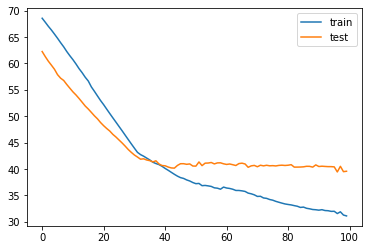

In [19]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [20]:
# make a prediction
yhat = model.predict(test_X)

In [21]:
yhat

array([[  5.478115 ],
       [ 46.284534 ],
       [ 61.28005  ],
       [ 82.842995 ],
       [ 71.879135 ],
       [  3.6679842],
       [-40.108128 ],
       [  9.4757805],
       [ 48.020428 ]], dtype=float32)

In [22]:
# split into train and test sets
values = reframed_residual.values

#n_total = round((values.shape[0])*80/100)
n_total = 413


train = values[:n_total, :]
test = values[n_total:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(413, 1, 11) (413,) (9, 1, 11) (9,)


Epoch 1/100
83/83 - 1s - loss: 68.6692 - val_loss: 62.2492
Epoch 2/100
83/83 - 0s - loss: 67.8231 - val_loss: 61.4727
Epoch 3/100
83/83 - 0s - loss: 67.1288 - val_loss: 60.6355
Epoch 4/100
83/83 - 0s - loss: 66.3579 - val_loss: 59.8629
Epoch 5/100
83/83 - 0s - loss: 65.5953 - val_loss: 58.9970
Epoch 6/100
83/83 - 0s - loss: 64.8274 - val_loss: 58.2677
Epoch 7/100
83/83 - 0s - loss: 63.9534 - val_loss: 57.4627
Epoch 8/100
83/83 - 0s - loss: 63.1968 - val_loss: 56.7177
Epoch 9/100
83/83 - 0s - loss: 62.4542 - val_loss: 56.1653
Epoch 10/100
83/83 - 0s - loss: 61.6346 - val_loss: 55.2881
Epoch 11/100
83/83 - 0s - loss: 60.7305 - val_loss: 54.6557
Epoch 12/100
83/83 - 0s - loss: 59.8590 - val_loss: 53.8712
Epoch 13/100
83/83 - 0s - loss: 59.0287 - val_loss: 53.2382
Epoch 14/100
83/83 - 0s - loss: 58.1811 - val_loss: 52.3194
Epoch 15/100
83/83 - 0s - loss: 57.3922 - val_loss: 51.8526
Epoch 16/100
83/83 - 0s - loss: 56.4519 - val_loss: 50.8421
Epoch 17/100
83/83 - 0s - loss: 55.6293 - val_los

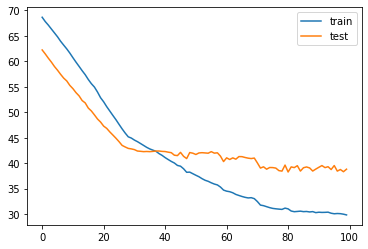

In [23]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
# make a prediction
yhat = model.predict(test_X)

In [25]:
yhat

array([[  5.9062815],
       [ 45.447372 ],
       [ 67.3991   ],
       [ 80.8993   ],
       [ 73.56805  ],
       [ -6.3852577],
       [-39.297752 ],
       [  3.514223 ],
       [ 45.096573 ]], dtype=float32)